Installations

In [ ]:
%pip install python-docx
%pip install python-pptx
%pip install PyPDF2
%pip install langchain
%pip install langchain_community
%pip install langchain_text_splitters
%pip install sentence-transformers
%pip install faiss-cpu
%pip install cohere
!pip install langchain-community chromadb
!pip install transformers tokenizers
!pip install rank_bm25
!pip install datasets
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.6/987.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cac

Imports

In [ ]:
from docx import Document
from PyPDF2 import PdfReader
from pptx import Presentation
from langchain_community.llms import Cohere
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AIMessage, HumanMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts  import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
import os
import openai
import getpass
import pandas as pd
from langchain_community.embeddings import SentenceTransformerEmbeddings
import chromadb
from chromadb.utils import embedding_functions
from IPython.display import display
import numpy as np
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as go
from sklearn.metrics import log_loss
from rank_bm25 import BM25Okapi
import time
from langchain_community.embeddings import HuggingFaceEmbeddings

Embedding Model

BAAI/bge-reranker-base

278 Million Parameters

In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name='BAAI/bge-reranker-base',
#    model_kwargs={'trust_remote_code': True}
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/sett

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at BAAI/bge-reranker-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Questions to feed the collection

In [ ]:
df=pd.read_csv('/content/Train Questions Version 2.csv', na_values=['NULL','NaN'], encoding='latin-1')

Test questions

In [ ]:
dftest=pd.read_csv('/content/Alternate Questions.csv', na_values=['NULL','NaN'], encoding='latin-1')

**BM25 Retreiver System**

In [ ]:
bm25 = BM25Okapi(df['Question'])

In [ ]:
query = dftest['Question'].iloc[0]

doc_scores = bm25.get_scores(query)
bm25.get_top_n(query, df['Question'], n=10)

[" I am a choreographer. So there's one doubt, that as a performer, when we listen to some music there's a music beat for every emotion So as a performer I am able to perform that very well according to the music what they demand.But as a person I am very confused about my life's emotions. Like I am super expressive I don't know what? I get too emotional sometimes and I can't even control it My mind will say stop but I can't So is it because of that feeling that I am stuck somewhere? our is it because I am not able to understand what's going on in my life? our what I want? ",
 "Gurudev, I have one personal regret. Why didn't I get you earlier in my life? So much difference has happened and than I have a regret for others because I find so many friends and people I know who really want to come, but there are some mundane things that put them off. What to do?",
 "I've been working in the gambling industry for the past 15 years.I see the negative effects of gambling on people. Is it wrong

Querying the BM25 Retreiver

In [ ]:
start_time = time.time()

query = "Did the ramayana and mahabharata happen?"

res=bm25.get_top_n(query, df['Question'], n=5)
print(res)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

["It is said that one's true calling is their Dharma.\nWhat is the link between our Dharma and our career and is it possible for my Dharma to be a job that I don't enjoy?", 'Gurudev, Bhishma Pitamah, Karna, and Guru Dronacharya supported Dharma all their lives. But why did they support Adharma at the end?', 'Gurudev, Krishna made Yudhisthira lie to defeat Dronacharya And he also made Arjuna break the rules to defeat Karna We understand that he did all these to uphold Dharma Does this also allow us to break the rules if you are working towards the betterment of the society? ', "â\x80\x9cIf a person's actions and thoughts are driven by past Karma,\n how do we switch lanes and act according to Dharma, and \nhow do we know what is our Dharma?â\x80\x9d", ' Gurudev, Lord Krishna were on the side of Pandavas. He knew that whichever side he is on will win. Despite that he gave his army to Kauravas. Did he have a different interpretation of Raj Dharma (rules of governance) as he knew his army w

Testing BM25

In [ ]:
def testing_bm25(q,k):
  o=bm25.get_top_n(q, df['Question'], n=k)
  doc_scores = bm25.get_scores(q)
  L=sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:k]
  return o,L,doc_scores

This line returns the indices of the top k recommendations of the BM25 retreiver

In [ ]:
sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:10]

[84, 175, 11, 9, 40, 87, 32, 259, 86, 77]

In [ ]:
indices=[]
for i in range(len(dftest)):
  a1,a2,a3=testing_bm25(dftest['Question'].iloc[i],10)
  indices.append(a2)

In [ ]:
dfi=pd.DataFrame(indices)
#dfind=dfi[dfi.columns[::-1]]

Indices of the top k recommendations for each test case

In [ ]:
dfi

,0,1,2,3,4,5,6,7,8,9
0,84,175,11,9,40,87,32,259,86,77
1,84,87,73,86,40,175,32,9,48,259
2,84,249,9,32,48,86,76,196,40,63
3,9,84,249,40,32,10,11,76,80,77
4,244,49,87,73,77,296,95,37,295,33
...,...,...,...,...,...,...,...,...,...,...
344,300,34,203,185,249,52,77,333,208,303
345,244,73,271,77,296,85,33,37,95,163
346,16,260,228,258,254,277,312,267,265,256
347,77,164,175,12,130,163,102,260,231,242


**Semantic Search using Vector DB**

In [ ]:
hf_ef = embedding_functions.HuggingFaceEmbeddingFunction(api_key = '<insert apikey here>')

In [ ]:
client = chromadb.Client()

In [ ]:
collection = client.create_collection(
        name="AGA",
    )

Indices to feed to the collection

In [ ]:
indices=[]
for i in range(len(df)):
  indices.append(str(i))

Create Metadata

In [ ]:
encoder = df['video_link'].unique()
encoder = {city: i for i, city in enumerate(encoder)}
df['url_metadata']=df['video_link'].map(encoder)

In [ ]:
start_time = time.time()

collection.add(ids=indices, documents=df['Question'].to_list(),metadatas=df[['url_metadata']].to_dict(orient='records'))

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:11<00:00, 6.97MiB/s]


Time taken: 65.24266242980957 seconds


In [ ]:
start_time = time.time()

results = collection.query(query_texts=dftest['Question'].iloc[0], n_results=10)
print(results)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

{'ids': [['192', '17', '1', '194', '0', '2', '195', '13', '10', '203']], 'distances': [[1.0182523727416992, 1.0218744277954102, 1.0443211793899536, 1.0672369003295898, 1.0801525115966797, 1.1099698543548584, 1.145219326019287, 1.1517421007156372, 1.1554481983184814, 1.1650913953781128]], 'metadatas': [[{'url_metadata': 11}, {'url_metadata': 0}, {'url_metadata': 0}, {'url_metadata': 11}, {'url_metadata': 0}, {'url_metadata': 0}, {'url_metadata': 11}, {'url_metadata': 0}, {'url_metadata': 0}, {'url_metadata': 11}]], 'embeddings': None, 'documents': [['As the leader of the Art of Living Organisation for decades and running it very successfully,have you felt any peer competition?', "How to not be jealous of others' success especially when you know them closely?", 'I work hard but do get success, some people who started with me are away ahead I am not jealous but worried about myself please help?', " What's the magic ingredient of success and how can we develop a successful mindset? ", 'Wha

**Ensemble System**

Function to return the ids and similarity scores for semantic search

In [ ]:
def output(q,k):
  similarity=[]
  allindices=[]
  o=collection.query(query_texts=[q],n_results=k)
  for i in range(k):
   similarity.append(1/(1+o['distances'][0][i]))
  for j in range(k):
    allindices.append(int(o['ids'][0][j]))
  return allindices,similarity

In [ ]:
def bm25predict(q,k):
  o=bm25.get_top_n(q, df['Question'], n=k)
  doc_scores = bm25.get_scores(q)
  L=sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:k]

  #return L,sorted(doc_scores)[len(doc_scores)-k:]

  return L,sorted(doc_scores/max(doc_scores),reverse=True)[:k]

In [ ]:
bm25predict(dftest['Question'].iloc[0],10)

([84, 175, 11, 9, 40, 87, 32, 259, 86, 77],
 [1.0,
  0.9899730049594225,
  0.9799914257587855,
  0.979126402181076,
  0.9766371694809016,
  0.9766099622211714,
  0.9734822010061585,
  0.9709190461864452,
  0.9701047580414358,
  0.969578237742927])

In [ ]:
output(dftest['Question'].iloc[0],10)

([192, 17, 1, 194, 0, 2, 195, 13, 10, 203],
 [0.49547817384282217,
  0.4945905572832084,
  0.4891599275503325,
  0.48373749512722275,
  0.48073398196770767,
  0.47394042049276514,
  0.46615280212658744,
  0.46473971005512926,
  0.4639406322917548,
  0.4618742664326923])

In [ ]:
L=[]
a,b=bm25predict(dftest['Question'].iloc[0],100)
c,d=output(dftest['Question'].iloc[0],100)
bm25normalized = [(x - min(b)) / (max(b) - min(b)) for x in b]
semanticscorenormalized = [(y - min(d)) / (max(d) - min(d)) for y in d]

In [ ]:
def ensemblesystem(q,k,r):
  #Normalizing the values
  L=[]
  a,b=bm25predict(q,r)
  c,d=output(q,r)
  bm25normalized = [(x - min(b)) / (max(b) - min(b)) for x in b]
  semanticscorenormalized = [(y - min(d)) / (max(d) - min(d)) for y in d]

  for i in range(r):
    for j in range(r):
      if a[i]==c[j]:
        L.append([a[i],0.3*bm25normalized[i]+0.7*semanticscorenormalized[j]])
  dataframel=pd.DataFrame(L)

  for z in range(r):
    if c[z] not in dataframel.iloc[:,0]:
      L.append([c[z],0.7*semanticscorenormalized[z]])
  dataframel=pd.DataFrame(L)

  for x in range(r):
    if a[x] not in dataframel.iloc[:,0]:
      L.append([a[x],0.3*bm25normalized[x]])

  dfl=pd.DataFrame(L).sort_values(by=[1],ascending=False)
  dfl2=dfl.drop_duplicates()

  return dfl2.iloc[:,0][:k],dfl2.iloc[:,1][:k]

Ensemble Model Predictions

In [ ]:
question=dftest['Question'].iloc[0]
ensemblesystem(question,10,100)

(4      87
 37    192
 9      13
 1     175
 38    194
 39     87
 15     10
 34      2
 16     46
 3       9
 Name: 0, dtype: int64,
 4     0.830030
 37    0.700000
 9     0.654676
 1     0.629966
 38    0.623895
 39    0.608908
 15    0.589900
 34    0.565878
 16    0.543318
 3     0.524670
 Name: 1, dtype: float64)

In [ ]:
start_time = time.time()

question=dftest['Question'].iloc[0]
ensemblesystem(question,10,100)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Time taken: 0.16483616828918457 seconds


Testing Semantic Search

In [ ]:
def testing_output(q,k):
  o=collection.query(query_texts=[q],n_results=k)
  similarities=[]
  L=[]
  idlist=[]
  for i in range(len(o['ids'][0])):
    L.append(df['Answer'].iloc[int(o['ids'][0][i])])
    similarities.append(o['distances'][0][i])
    idlist.append(int(o['ids'][0][i]))
  return L,similarities,idlist

In [ ]:
testing_output(dftest['Question'].iloc[0],10)

(["In fact, I don't run at all I just give what I have what I know Where is the competition? Competition is when you want to get something You want to achieve something It is only a matter of giving Even in giving there is no effort When there is no effort there is no competition No challenge",
  " Just look up and see, on this planet, so many people have been there.Cleopatra has been here. Alexander the Great has been here. There has been so many, many such great men and women who have walked on this path and they've all... The ultimate place for them all is their grave. So, even the person on whom you're jealous, they're not going to be here permanently. One day, they'll also hit the mud.Right? They will merge in the soil. So, know this. Everything in this life is temporary. Everything is ephemeral here, even your life. You're not going to be here forever. You're in a transit launch, my dear. Do you get jealous in the transit launch because someone is sitting in a comfortable chair? 

Testing on test questions

In [ ]:
simlist=[]
indexlist=[]
for i in range(len(dftest)):
  s1,s2=ensemblesystem(dftest['Question'].iloc[i],10,100)
  indexlist.append(list(s1))
  simlist.append(list(s2))

In [ ]:
pd.DataFrame(simlist)

,0,1,2,3,4,5,6,7,8,9
0,0.830030,0.700000,0.654676,0.629966,0.623895,0.608908,0.589900,0.565878,0.543318,0.524670
1,0.750941,0.700000,0.678804,0.672469,0.665612,0.624741,0.554400,0.551436,0.526112,0.517231
2,0.767185,0.732604,0.690482,0.663216,0.650139,0.637041,0.541395,0.489921,0.470858,0.440574
3,0.797408,0.621702,0.540958,0.513293,0.506499,0.421278,0.408092,0.403492,0.394388,0.385088
4,0.330260,0.300000,0.270027,0.212012,0.211746,0.207561,0.192527,0.170007,0.160707,0.149940
...,...,...,...,...,...,...,...,...,...,...
344,0.844023,0.811032,0.700000,0.566949,0.550881,0.453810,0.450705,0.435349,0.428568,0.426513
345,0.700000,0.306742,0.306413,0.300000,0.287961,0.278372,0.251123,0.241010,0.230345,0.223120
346,0.856985,0.700000,0.398945,0.369480,0.340294,0.332722,0.317464,0.311308,0.292666,0.281404
347,0.700000,0.273224,0.267950,0.261310,0.247016,0.245365,0.242537,0.239989,0.216469,0.215907


Testing Results

In [ ]:
dfindexlist=pd.DataFrame(indexlist)
dfindexlist

,0,1,2,3,4,5,6,7,8,9
0,87,192,13,175,194,87,10,2,46,9
1,87,195,9,10,200,194,79,38,204,87
2,46,238,13,238,46,87,84,9,41,79
3,13,83,9,87,83,46,10,84,36,192
4,194,244,195,87,37,49,85,296,295,38
...,...,...,...,...,...,...,...,...,...,...
344,209,333,209,333,217,230,221,217,225,317
345,335,332,85,244,316,321,271,271,332,322
346,335,335,290,274,228,258,16,290,191,277
347,335,321,206,260,164,332,163,175,130,163


Data

In [ ]:
dfx=pd.read_csv('/content/Train Questions.csv', na_values=['NULL','NaN'], encoding='latin-1')

In [ ]:
lts=[]
for i in range(len(dftest)):
  for j in range(len(df)):
    if dftest['Answer'].iloc[i]==dfx['Answer'].iloc[j]:
      lts.append(j)

In [ ]:
dfgroundtruth=pd.DataFrame(lts)

Empty dataframe to store hits in

Using Indices

In [ ]:
q1 = pd.DataFrame(index=range(len(dfindexlist)), columns=dfindexlist.columns)
fill_value=0
q1.fillna(fill_value, inplace=True)

In [ ]:
dfgroundtruth

,0
0,1
1,1
2,1
3,1
4,2
...,...
344,333
345,335
346,335
347,335


In [ ]:
acc=[]
resultdf=pd.DataFrame()
for i in range(len(dfindexlist)):
  for j in range(len(dfindexlist.columns)):
    if dfindexlist.iloc[i][j]==dfgroundtruth[0].iloc[i]:
      q1.iloc[i,j]=1
      acc.append(1)
    else:
      acc.append(0)

Value Counts

In [ ]:
for i in range(len(q1.columns)):
  print(q1.iloc[:,i].value_counts())

0
1    288
0     61
Name: count, dtype: int64
1
0    179
1    170
Name: count, dtype: int64
2
0    327
1     22
Name: count, dtype: int64
3
0    337
1     12
Name: count, dtype: int64
4
0    334
1     15
Name: count, dtype: int64
5
0    347
1      2
Name: count, dtype: int64
6
0    348
1      1
Name: count, dtype: int64
7
0    346
1      3
Name: count, dtype: int64
8
0    345
1      4
Name: count, dtype: int64
9
0    347
1      2
Name: count, dtype: int64


In [ ]:
count=q1.iloc[:,0]
accuracyatk=[]
for i in range(len(q1.columns)):
  count=count+q1.iloc[:,i]
  sum=0
  for i in range(len(count)):
    if count[i]==0:
      sum=sum+1
  accuracyatk.append(1-sum/(len(count)))
  print(1-sum/(len(count)))

0.8252148997134671
0.8624641833810889
0.8853868194842407
0.8997134670487106
0.9140401146131805
0.9140401146131805
0.9140401146131805
0.9169054441260744
0.9197707736389684
0.9226361031518625


Accuracy at K

In [ ]:
pd.DataFrame(accuracyatk)

,0
0,0.825215
1,0.862464
2,0.885387
3,0.899713
4,0.914040
5,0.914040
6,0.914040
7,0.916905
8,0.919771
9,0.922636


Predictions

Ground Truth

In [ ]:
dftest['Answer']

0      Worry simply means your are not aware of your ...
1      Worry simply means your are not aware of your ...
2      Worry simply means your are not aware of your ...
3      Worry simply means your are not aware of your ...
4      Luck is a gift it's not something what you ear...
                             ...                        
344    Enlightenment means getting rid of all Sanchit...
345    oh yeah yeah Devas also have karmas  Devas als...
346    oh yeah yeah Devas also have karmas  Devas als...
347    oh yeah yeah Devas also have karmas  Devas als...
348    oh yeah yeah Devas also have karmas  Devas als...
Name: Answer, Length: 349, dtype: object

Distances

In [ ]:
dfdistlist=pd.DataFrame(simlist)

In [ ]:
dfsimlist=1-dfdistlist

Relationship between distance and accuracy

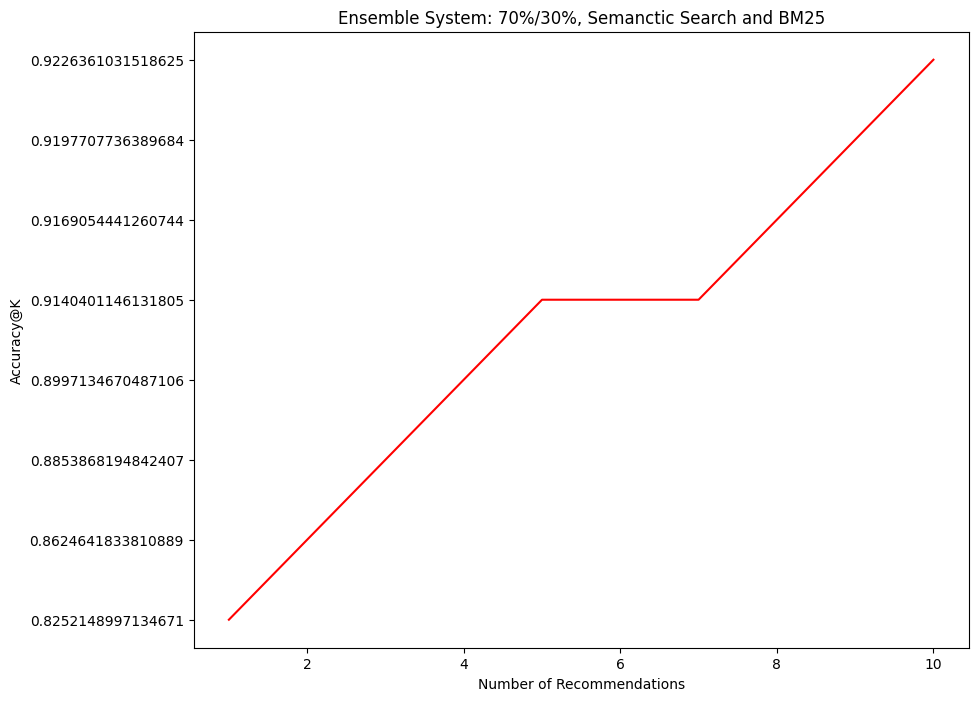

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

x=[1,2,3,4,5,6,7,8,9,10]
y=['0.8252148997134671','0.8624641833810889','0.8853868194842407','0.8997134670487106','0.9140401146131805','0.9140401146131805','0.9140401146131805',
'0.9169054441260744','0.9197707736389684','0.9226361031518625']


fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8), sharex=True)

ax1.plot(x, y, color='red')
ax1.set_title('Ensemble System: 70%/30%, Semanctic Search and BM25')
ax1.set_xlabel('Number of Recommendations')
ax1.set_ylabel('Accuracy@K')

plt.subplots_adjust(hspace=0.5)

plt.show()

In [ ]:
fig = px.scatter(x=dfsimlist.iloc[:,0], y=q1.iloc[:,0], trendline="ols")

fig.update_layout(
    title='Scatter Plot',
    xaxis_title='Cosing Similarity',
    yaxis_title='Prediction',
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as go
from sklearn.metrics import log_loss


In [ ]:
X = dfsimlist.iloc[:,0].values.reshape(-1, 1)
y = q1.iloc[:,0].values
model = LogisticRegression()

In [ ]:
model.fit(X,y)

intercept = model.intercept_[0]
slope = model.coef_[0][0]

x_plot = np.linspace(dfsimlist.iloc[:,0].min(), dfsimlist.iloc[:,0].max(), 100)

y_pred = model.predict_proba(x_plot.reshape(-1, 1))[:, 1]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dfsimlist.iloc[:,0],
    y=q1.iloc[:,0],
    mode='markers',
    name='Data Points'
))

fig.add_trace(go.Scatter(
    x=x_plot,
    y=y_pred,
    mode='lines',
    name='Logistic Regression Curve'
))

fig.update_layout(
    xaxis_title='Cosine Similarity',
    yaxis_title='Prediction',
    title='Logistic Regression Model'
)